In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import time 
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [3]:
## population and age classes
M=4  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/India-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

# scale the population down to a more manageble level 
Ni[0] = (np.sum(Ni0[0:4])/1e4).astype('int')
Ni[1] = (np.sum(Ni0[4:8])/1e4).astype('int')
Ni[2] = (np.sum(Ni0[8:12])/1e4).astype('int')
Ni[3] = (np.sum(Ni0[12:16])/1e4).astype('int')
N=np.sum(Ni)
print(N)
fi = Ni/N 

135333.0


In [4]:
# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.India()


CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))


for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4, j1:j1+4] )
        CW[i,j] = np.sum( CW0[i1:i1+4, j1:j1+4] )
        CS[i,j] = np.sum( CS0[i1:i1+4, j1:j1+4] )
        CO[i,j] = np.sum( CO0[i1:i1+4, j1:j1+4] )

In [5]:
# Generate class with contact matrix for SIR model with UK contact structure
generator = pyross.contactMatrix.SIR(CH, CW, CS, CO)

In [47]:
times= [20] # temporal boundaries between different contact-behaviour

aW, aS, aO = 0.5, 0.6, 0.6

# prefactors for CW, CS, CO:
interventions = [[1.0,1.0,1.0],      # before first time
                 [aW, aS, aO],       # after first time
                ]         

# generate corresponding contact matrix function
C = generator.interventions_temporal(times=times,interventions=interventions)

In [48]:
beta  = 0.00454      # contact rate parameter
gIa   = 1./7            # recovery rate of asymptomatic infectives 
gIs   = 1./7            # recovery rate of symptomatic infectives 
alpha = 0.2              # asymptomatic fraction
fsa   = 0.8               # suppresion of contact by symptomatics


# initial conditions    
Is_0 = np.ones(M)*20
Is_0[1] += 10 #make one group different 
Ia_0 = np.zeros((M))*2
Ia_0[1] += 2 
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)


parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
model = pyross.stochastic.SIR(parameters, M, Ni)

contactMatrix=C

# start simulation
Tf=100;  Nf=Tf+1 
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf)

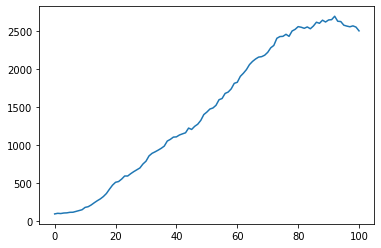

In [49]:
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
t = data['t']
plt.plot(t, IC)
plt.show() 

-990.3951725892858
0.19268512725830078


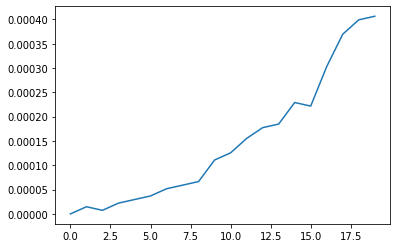

In [50]:
Tf = 19 # truncate to only getting the first few datapoints 
Nf = Tf+1

x = data['X']
x = (x/N)[:Nf]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

plt.plot(x[:, M])
plt.show()

In [32]:
# take a guess 
beta_g = 0.005
gIa_g = 0.15
gIs_g = 0.15
alpha_g = 0.25
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g])

# compute -log_p for the initial guess 
parameters = {'alpha':alpha_g, 'beta':beta_g, 'gIa':gIa_g, 'gIs':gIs_g,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
print(logp) 

eps = 1e-4 
bounds = np.array([(eps, 0.4), (1e-3, 0.02), (eps, 0.3), (eps, 0.3)]) # give some bounds
start_time = time.time() 
params, nit = estimator.inference(guess, x, Tf, Nf, contactMatrix, beta_rescale=5,
                                  niter=4, bounds=bounds, 
                                  eps=eps, verbose=True)
# sometimes produce errors if input is bad, ignore and let basinhopping do its magic
end_time = time.time()
print(params) # best guess 
print(nit) # number of iterations of the optimization run 
print(end_time - start_time)

-960.0991798111395
[[1.e-04 4.e-01]
 [5.e-03 1.e-01]
 [1.e-04 3.e-01]
 [1.e-04 3.e-01]]
parameters: [0.22375084 0.02289923 0.1657558  0.13425471]
parameters: [0.22574118 0.02204733 0.16458928 0.13559042]
parameters: [0.22434537 0.02233485 0.16542274 0.13473102]
parameters: [0.22436232 0.02232252 0.16541943 0.13477614]
basinhopping step 0: f -973.28
parameters: [0.19619869 0.0422336  0.15962238 0.144826  ]
parameters: [0.18796127 0.0285561  0.16482843 0.14908757]
parameters: [0.18745264 0.02242371 0.1649423  0.14866399]
parameters: [0.1939295  0.02239767 0.16029158 0.14349585]
parameters: [0.20881063 0.02233631 0.1517252  0.14018773]
parameters: [0.21008296 0.02236469 0.15255269 0.14059737]
parameters: [0.21111448 0.02235452 0.15333852 0.14076831]
parameters: [0.21215941 0.02236287 0.154552   0.14070117]
parameters: [0.21647537 0.02236147 0.16034768 0.13989182]
parameters: [0.21987233 0.0223635  0.16587303 0.13849603]
parameters: [0.2220996  0.02233839 0.17070344 0.13694965]
parameters:

In [51]:
aW_g = 0.5 
aW_bounds = [0.1, 0.8]
aS_g = 0.5
aS_bounds = [0.1, 0.8]
aO_g = 0.5
aO_bounds = [0.1, 0.8]
guess = np.array([aW_g, aS_g, aO_g])
bounds = np.array([aW_bounds, aS_bounds, aO_bounds])

x = data['X']/N
x = x[22:]
Nf = x.shape[0] 
Tf = Nf-1 

times = [Tf+1]
interventions = [[aW, aS, aO]]
contactMatrix = generator.interventions_temporal(times=times,interventions=interventions)

# compute -log_p for the initial guess (for the moment, use correct parameters)
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
print(logp) 

-3041.727528691351


In [52]:
eps = 1e-3 
start_time = time.time() 

params, nit = estimator.infer_control(guess, x, Tf, Nf, generator, bounds,
                                  niter=2, eps=eps, verbose=True)
# sometimes produce errors if input is bad, ignore and let basinhopping do its magic
end_time = time.time()
print(params) # best guess 
print(nit) # number of iterations of the optimization run 
print(end_time - start_time)

parameters: [0.57685583 0.57685583 0.57685583]
parameters: [0.5686592  0.576323   0.57495062]
parameters: [0.53779135 0.58074987 0.57326777]
parameters: [0.51172485 0.58944286 0.5768395 ]
parameters: [0.50100206 0.59349122 0.58267747]
parameters: [0.50053585 0.59324775 0.58365781]
parameters: [0.50015123 0.59244072 0.58456766]
parameters: [0.49878858 0.58946443 0.58699879]
parameters: [0.49592756 0.58345229 0.59106302]
parameters: [0.49216157 0.575988   0.59524537]
parameters: [0.49090476 0.57337212 0.5961746 ]
parameters: [0.49090476 0.57337212 0.5961746 ]
basinhopping step 0: f -3043.83
parameters: [0.42099897 0.55571909 0.57224579]
parameters: [0.44878172 0.58728312 0.60676924]
parameters: [0.4493345  0.58221838 0.60284187]
parameters: [0.45451923 0.57769064 0.60081069]
parameters: [0.47093965 0.56909569 0.5989269 ]
parameters: [0.48493835 0.56578929 0.59982247]
parameters: [0.48739772 0.56638685 0.60024463]
parameters: [0.48749314 0.56674156 0.60022806]
basinhopping step 1: f -3043